In [1]:
from feature_engineering import date_features, impute
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../Data/merged_cleaned.csv')
#Mimic the state in "feature_engineering_w.py", when weather features are added.
df = impute(df)
weather = pd.read_csv("../Data/weather.csv")
weather['Date'] = pd.to_datetime(weather['time'])
weather = weather.drop("time", axis='columns')

In [3]:
weather.columns

Index(['weathercode (wmo code)', 'temperature_2m_max (°C)',
       'temperature_2m_min (°C)', 'temperature_2m_mean (°C)',
       'apparent_temperature_max (°C)', 'apparent_temperature_min (°C)',
       'apparent_temperature_mean (°C)', 'sunrise (iso8601)',
       'sunset (iso8601)', 'shortwave_radiation_sum (MJ/m²)',
       'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'precipitation_hours (h)', 'windspeed_10m_max (km/h)',
       'windgusts_10m_max (km/h)', 'winddirection_10m_dominant (°)',
       'et0_fao_evapotranspiration (mm)', 'Date'],
      dtype='object')

---

### Temperature
There are "MIN, MAX, MEAN" temperatures given for two categories.

- Apparent temperature
- 2 meter above the ground real temperature

There is obviously informational interest in using the apparent temperature values as these are the ones that are perceived by potential customers and can potentially quite differ from the actual value:

In [4]:
mean_diff = np.mean(
    weather["apparent_temperature_mean (°C)"] - weather["temperature_2m_mean (°C)"]
)
print(f"Mean difference between Mean 2m-temperature and mean apparent temperature:\n{mean_diff:.2f} °C\n")

mean_temp = np.mean(weather["temperature_2m_mean (°C)"])
print(f"Mean Temperature: \n{mean_temp:.2f} °C \n")

mean_perc = (
    np.mean(
        (
            weather["apparent_temperature_mean (°C)"]
            - weather["temperature_2m_mean (°C)"]
        )
        / weather["temperature_2m_mean (°C)"]
    )
    * 100
)
print(
    f"Mean precentage difference between apparent and actual temperature mean values:\n{mean_perc:.2f} %\n"
)

mean_diff_min_max = np.mean(weather['temperature_2m_max (°C)'] - weather['temperature_2m_min (°C)'])
print(f"Mean difference between min and max of actual temperature: \n{mean_diff_min_max:.2f} °C")

Mean difference between Mean 2m-temperature and mean apparent temperature:
-2.13 °C

Mean Temperature: 
12.16 °C 

Mean precentage difference between apparent and actual temperature mean values:
-5.91 %

Mean difference between min and max of actual temperature: 
6.88 °C


In my opinion there are some reasons why converting numerical temperatures values into categorical ones should not be done:
- Potential information loss as categories are set by a human. As we are using algorithms based on the decision tree learning process, the splitting can also be done in the numerical domain, therefore increasing the potential information content that can be extracted from the temperature feature
- One could argue that ordering the values into categories might decrease statistical variance of the feature, therefore also reducing the potential erronous variance of the model output. But as the threshold values for categorizing the temperature are also set "arbitrarily" one could even influnce this behaviour in a negative way as the variance that is based on noise can also act around the threshold value, resulting in fluctuating temperature categories, and the original real temperature range is lost:
- e.g.: if Category C1 is from 10 - 15 °C and Category C2 from 15 - 20 °C then a fluctuation <br>
$C1 \rightarrow C2 \rightarrow C1$ could originate from <br>
<br>
11 °C $\rightarrow$ 19 °C $\rightarrow$ 11 °C <br> or from  <br> 14.5 °C $\rightarrow$ 15.5 °C $\rightarrow$ 14.5 °C

As we do not expand the values into several columns via one-hot-encoding of category-features. It might be okay to carry all 6 temperature columns with us.

One thing that we still have to consider is the relation of apparent to actual temperature as there is also a lot of information contained in their ratio. It can contain important human-feeling-oriented information about humidity, sunshine, etc. as they all influence the "behvioral" change of apparent temperature.

But both basic algorithms that are typically used together with these features, decision trees and neural nets are easily able to learn this "differential" information as in decision trees predictions can rely on nodes that come before, therefore being able to set relations in between features.

>##### !!! This might lead to a problem when using regularization and reducing tree depth to stomps

And in neural networks it is easily possible to learn weights that calculate even weighted differences in between two (and more) features. 

### Sunrise and Sunset

- Sunrise and sunset timestamp heavily base on the date of the year as we are in Germany.

>###### !!! If using this feature for input, one has to be careful to not produce information leakage and therefore letting a model learn memorizing instead of predicting as daylight time correlates heaviliy with the date itself. 

- Sunrise and Sunset will be combined into "day_light" by calculating the total time sun have been above the horizon:


In [5]:
day_light = pd.DataFrame(
    pd.to_datetime(weather["sunset (iso8601)"])
    - pd.to_datetime(weather["sunrise (iso8601)"]),
    columns=['sunhours']
)
day_light['sunhours'] = day_light['sunhours'].apply(lambda x: x.total_seconds()).astype(float) / (60 * 60)
day_light["Date"] = pd.to_datetime(weather["Date"])

And plot the day_light:

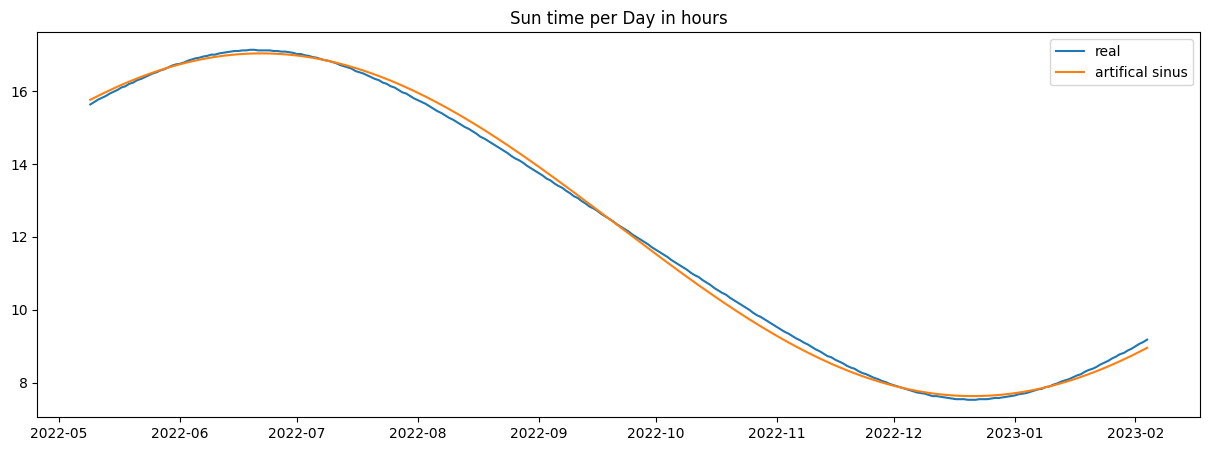

In [6]:
amplitude = 4.7
phase = 0.26 * np.pi
circ_freq = 2 * np.pi / 365  # days per year
offset = np.mean(day_light["sunhours"])

plt.rcParams["figure.figsize"] = (15, 5)
plt.title("Sun time per Day in hours")
plt.plot(day_light["Date"], day_light["sunhours"], label="real")
plt.plot(
    day_light["Date"],
    day_light.index.to_series().apply(
        lambda x: (amplitude * np.sin(x * circ_freq + phase)) + offset
    ),
    label="artifical sinus",
)
plt.legend()

As this information is totally sinusoidal there is no information gain (e.g. it is fully predictable).

=> The argument for memory-learning of the model applies still, so this feature can be dropped without losing anything.

(Another argument is, that it also totally mimics the behaviour of the "Day-of-year"- FFT, as it has a one-year-period too. It  possesses a different amplitude, phase and mean value, but there is still no information gain by using this feature.)

---

The other Weather features that we still have to handle are:

In [7]:
other = ['shortwave_radiation_sum (MJ/m²)',
       'precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'precipitation_hours (h)', 'windspeed_10m_max (km/h)',
       'windgusts_10m_max (km/h)', 'winddirection_10m_dominant (°)',
       'et0_fao_evapotranspiration (mm)']

def plot_other():
    for label in other:
        plt.plot(weather['Date'], weather[label], label=label)

    plt.legend()

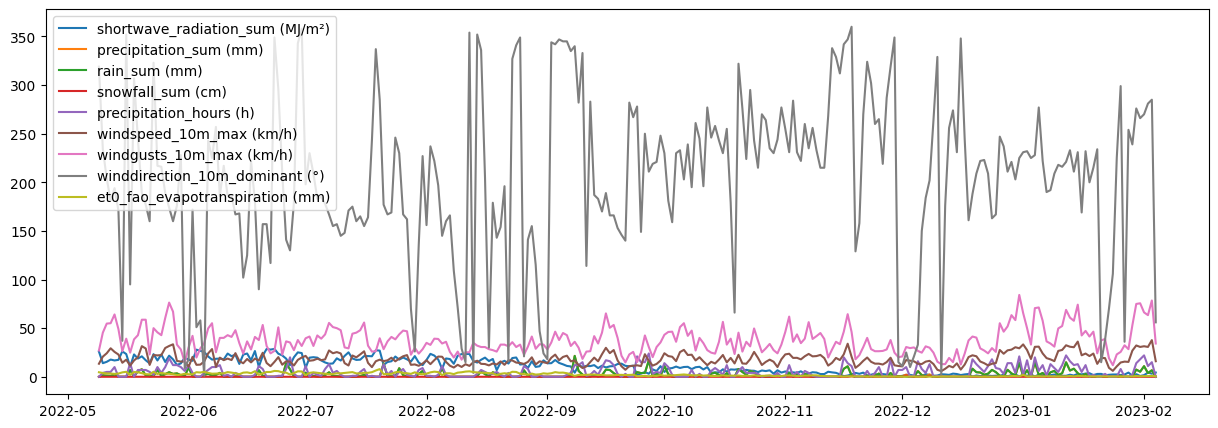

In [8]:
plot_other()

It is easy to argue that we have to drop the winddirection_10m_dominant(°) as it has a lot of variance and should have nothing to do with customers debating about buying/eating sushi or not. It will only result in unnecessary noise in the model prediction, which the model has to abstract from while learning, so one can save time and ressources with excluding it from the ongoing process.

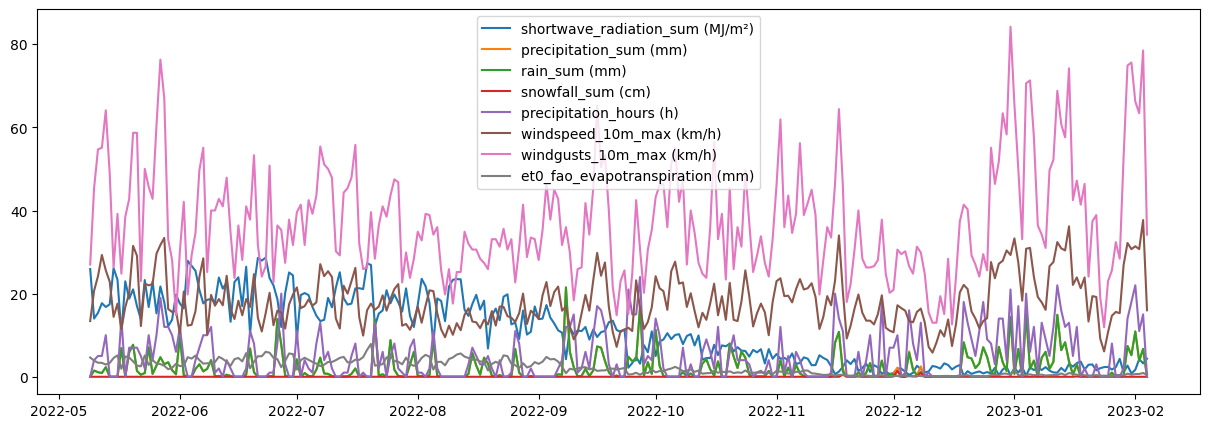

In [9]:
other.remove('winddirection_10m_dominant (°)')
plot_other()

---
Precipitation was divided into two subclasses:
 - snowfall
 - rain

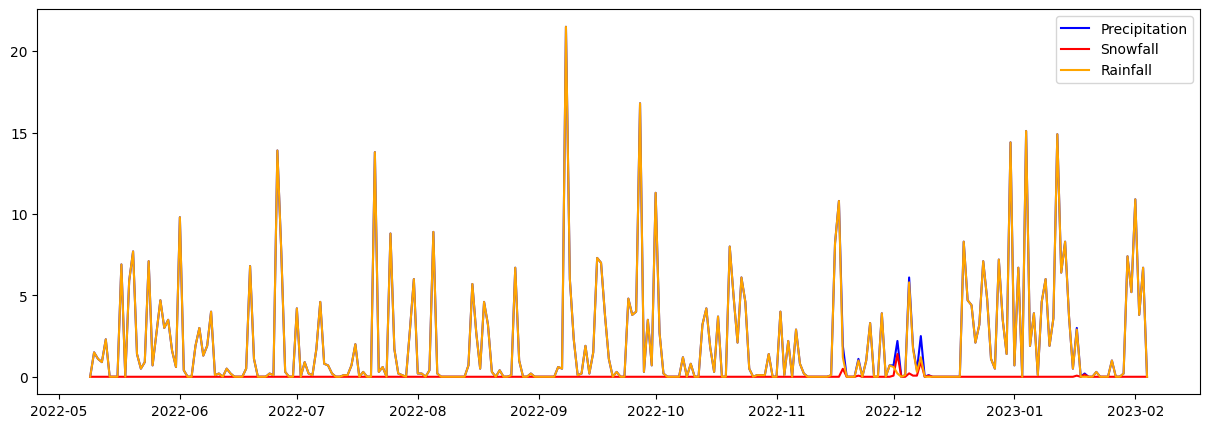

In [10]:
plt.plot(weather['Date'], weather['precipitation_sum (mm)'], color='blue', label='Precipitation')
plt.plot(weather['Date'], (weather['snowfall_sum (cm)']), color='red', label='Snowfall')
plt.plot(weather['Date'], weather['rain_sum (mm)'], color='orange', label='Rainfall')
plt.legend()

There are a few different options how to handle this data:
- include all three series'
- just use "precipitation" as this combines the other two
- use "snowfall" and "rainfall" and remove "precipitation" as the latter is only a (linear) combination of the other two therefore not adding information
- use precipitation and add a boolean indicator "snowfall" when there was snow falling on that day


One could still argue that adding the Snowfall as a feature on it's own is not too good:

In [11]:
print("Total Snowfall Datapoints: ", len(list(weather['snowfall_sum (cm)'])))
print("Non-Zero Snowfall Datapoints", len([x for x in list(weather['snowfall_sum (cm)']) if x != 0]))

Total Snowfall Datapoints:  272
Non-Zero Snowfall Datapoints 11


As this feature is extremely sparse therefore drastically increasing the chance of overfitting to the training set when using decision trees (only a tiny subset of the training data will end up in a node with "snowfall == true"). 
But as we propose a method to handle sparse dataset with MELeRSeD we obviously want to keep it.

Therefore it does make sense to go with the last option: "Precipitation" + Boolean "Snow indicator" 

---

Left to discuss:  ['shortwave_radiation_sum (MJ/m²)', 'precipitation_hours (h)', 'windspeed_10m_max (km/h)', 'windgusts_10m_max (km/h)', 'et0_fao_evapotranspiration (mm)']


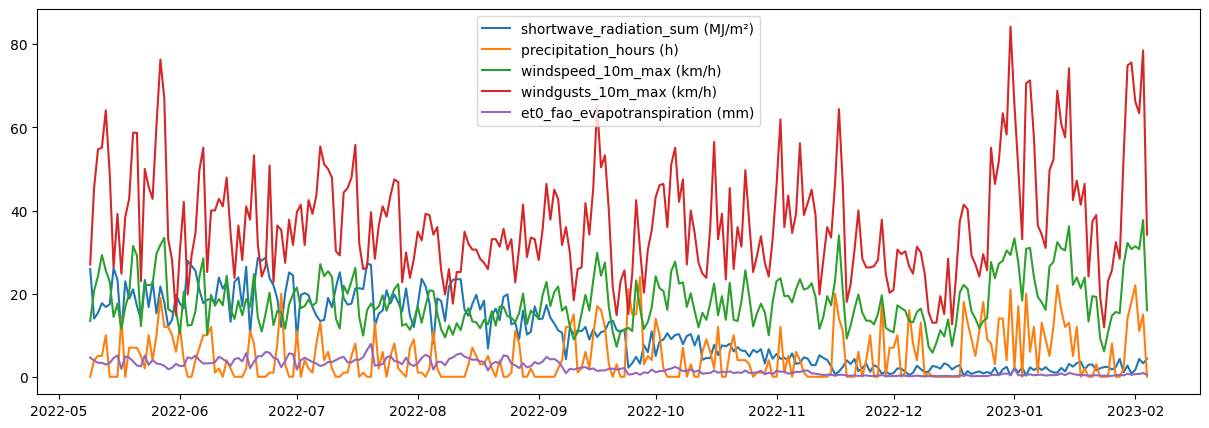

In [12]:
other.remove('snowfall_sum (cm)')
other.remove('rain_sum (mm)')
other.remove('precipitation_sum (mm)')
print("Left to discuss: ", other)
plot_other()

Shortwave radiation is a good indicator on what type of warmth the sun emitted on that perticular day

Precipitation hours together with the windspeed gives a good indicator on what type of weather was present on that day.

> Both of these could potentially give hints on the consumption behaviour of sushi eaters




Keeping both windspeed and windgusts seems not really productive first because they seem to correlate extremely when looking on the graph, but:  


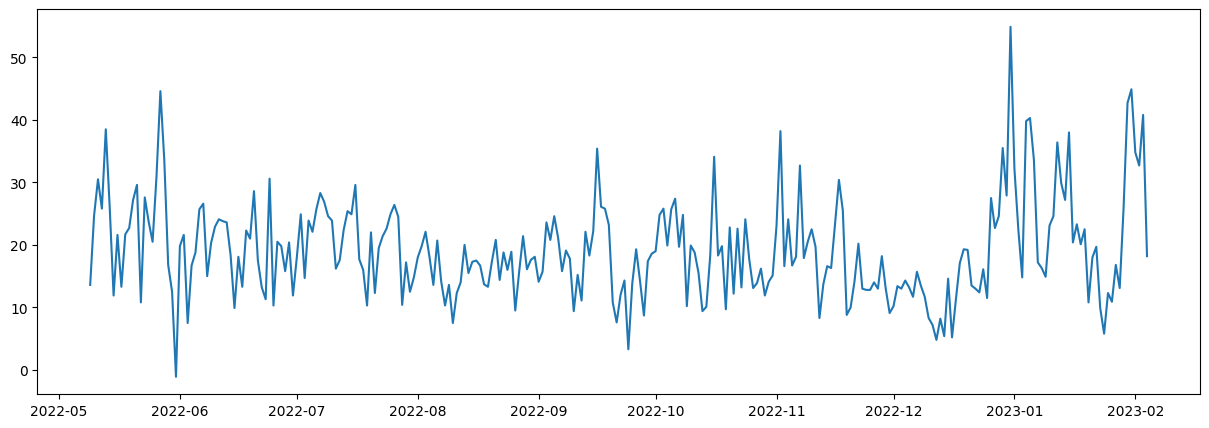

In [13]:
plt.plot(weather['Date'], weather['windgusts_10m_max (km/h)'] - weather['windspeed_10m_max (km/h)'] )

272


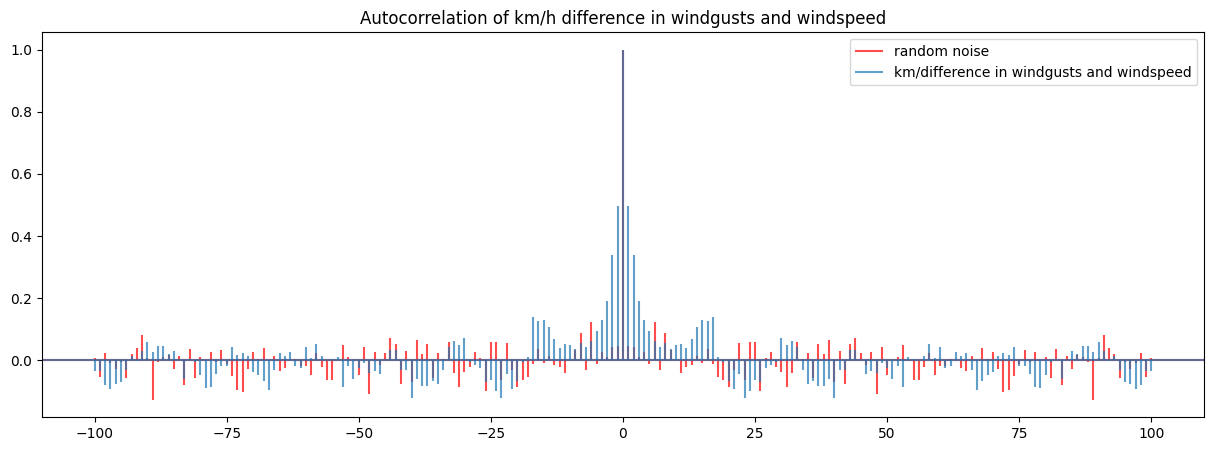

In [14]:
plt.title("Autocorrelation of km/h difference in windgusts and windspeed")
difference = weather["windgusts_10m_max (km/h)"] - weather["windspeed_10m_max (km/h)"]
print(len(difference))
noise = np.random.normal(0, 10, len(difference))
plt.acorr(
    noise,
    maxlags=100,
    label="random noise",
    color="red",
    alpha=0.7,
)
plt.acorr(
    (difference.to_numpy() - np.mean(difference)),
    maxlags=100,
    label="km/difference in windgusts and windspeed",
    alpha=0.7,
)
plt.legend()

Autocorrelation of difference


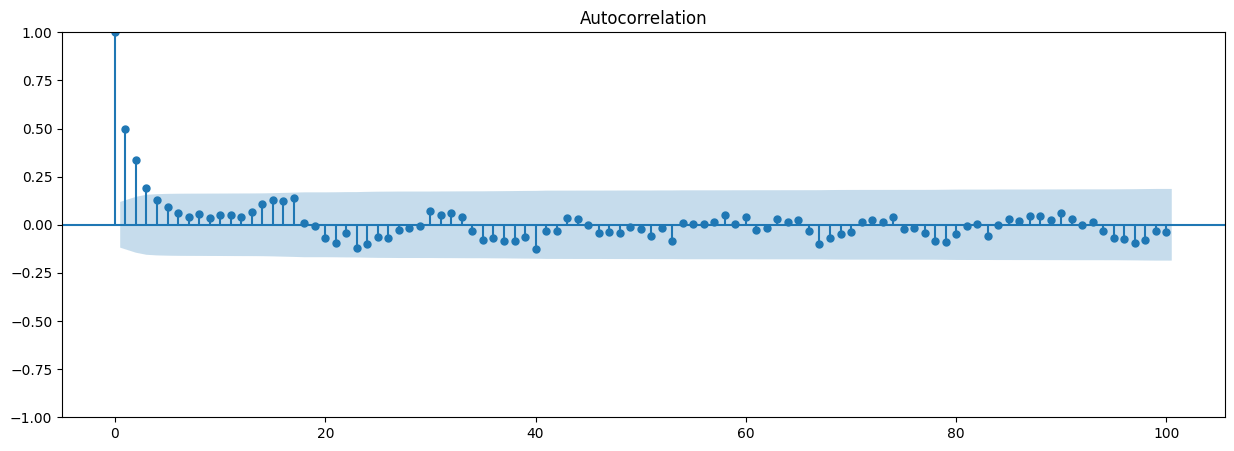

In [15]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(difference, lags=100)
print("Autocorrelation of difference")

The correlation analysis shows that there is some correlation in between the first few lags. This makes sense as the difference between the two wind-speed features are systematically, so a difference difference on one day results in a similar one on the next. It is questionable if this feauture really gives essential information but the correlation is not weak anough as if it could be called "just noise". Therefore we keep both in the dataset. The argument about weather to include the residuals, etc. is obsolete because of the reason mentioned above.

In [16]:
other.remove("windgusts_10m_max (km/h)")
other.remove("windspeed_10m_max (km/h)")
other.remove("shortwave_radiation_sum (MJ/m²)")
other.remove("precipitation_hours (h)")

---
#### Evapotranspiration

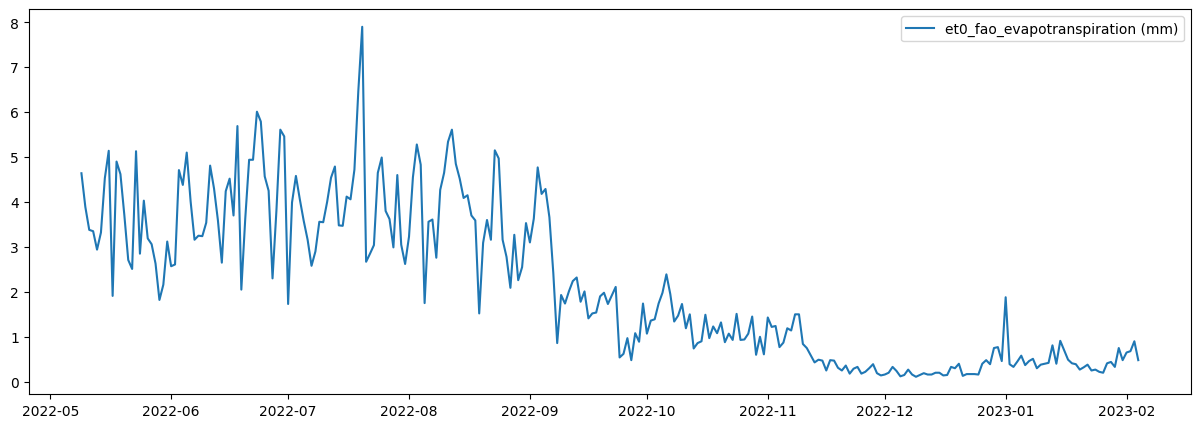

In [17]:
plot_other()


This seems really sinusoidal again. And it is, as the Fourier analysis shows:

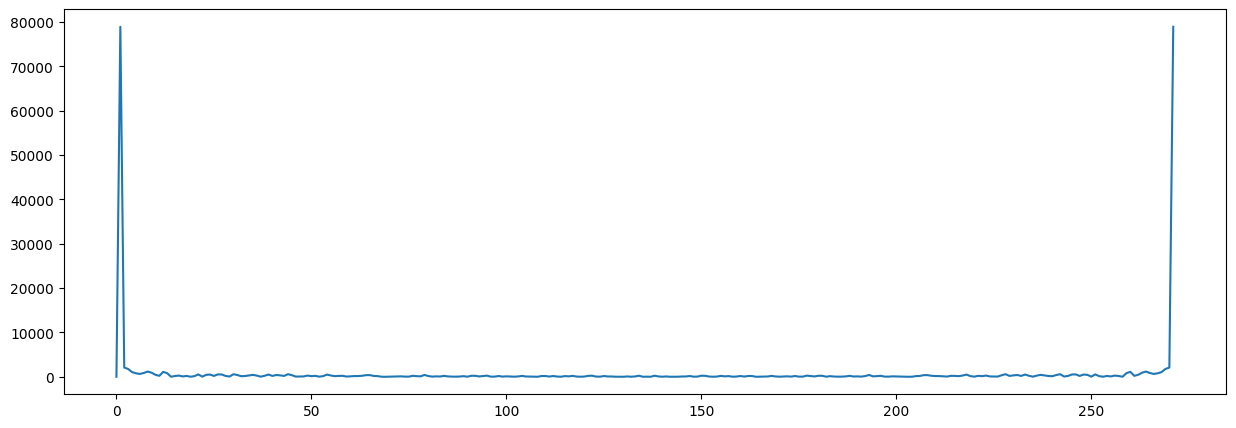

In [18]:
FFT = np.fft.fft(weather["et0_fao_evapotranspiration (mm)"])
FFT[0] = 0
plt.plot(np.real(FFT * np.conjugate(FFT)))

Try to fit a curve:

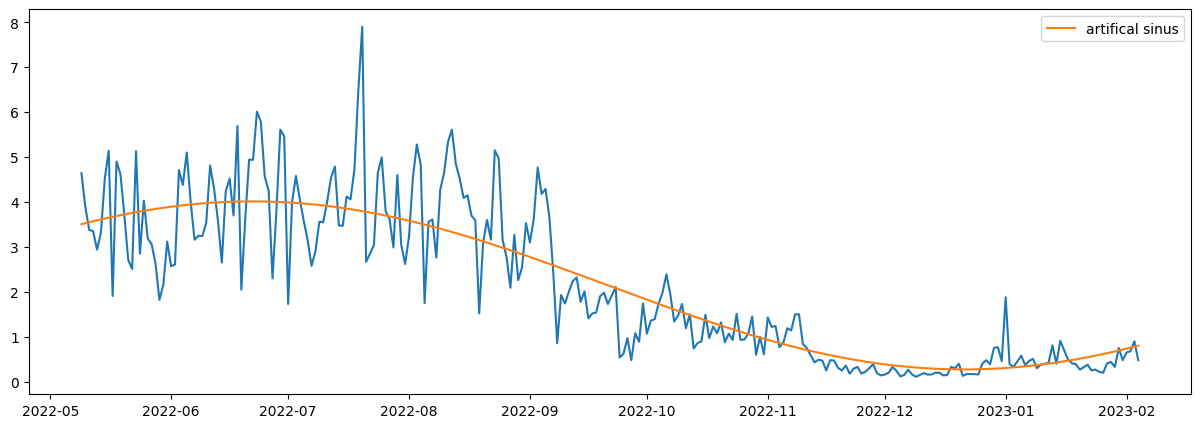

In [19]:
plt.plot(weather["Date"], weather["et0_fao_evapotranspiration (mm)"])
amplitude = 1.87
phase = 0.26 * np.pi
circ_freq = 2 * np.pi / 365  # days per year
offset = np.mean(weather["et0_fao_evapotranspiration (mm)"])
sinus_curve_estimate = weather.index.to_series().apply(
    lambda x: (amplitude * np.sin(x * circ_freq + phase)) + offset
)

plt.plot(
    weather["Date"],
    sinus_curve_estimate,
    label="artifical sinus",
)
plt.legend()

The residuals:

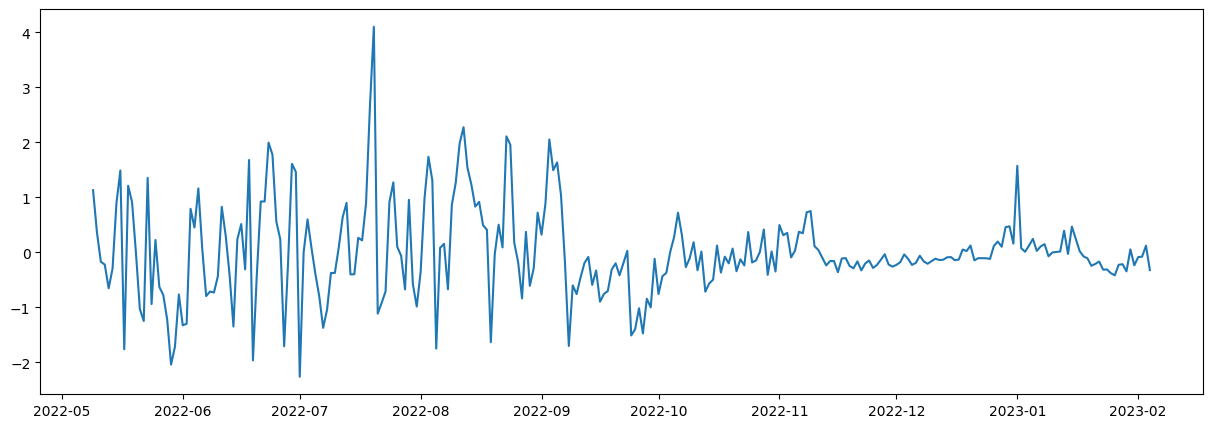

In [20]:
residuals = weather["et0_fao_evapotranspiration (mm)"] -  sinus_curve_estimate
plt.plot(weather['Date'], residuals)

And their autocorrelation:

Autocorrelation of residuals


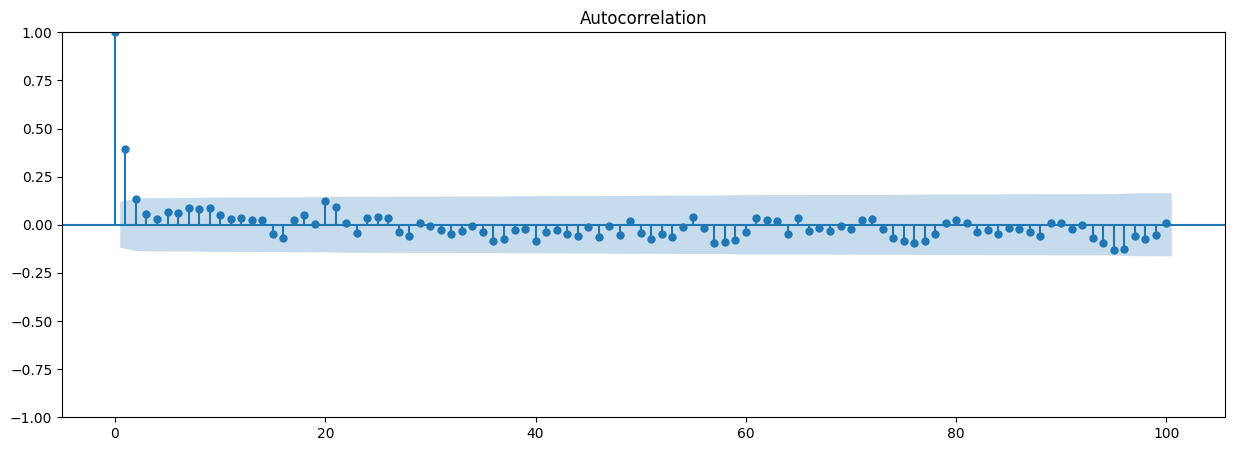

In [21]:
sm.graphics.tsa.plot_acf(residuals, lags=100)
print("Autocorrelation of residuals")

Seems like it is a ARMA-1 process again. We can therefore include the feature in our dataset. But we will use the residuals without the sine-based-curve as this reduces the change of memory-learning by the model.

--- 

## Weathercode:

There are not too many different weather codes in the dataset:


In [22]:
set(weather['weathercode (wmo code)'])

{0, 1, 2, 3, 51, 53, 55, 61, 63, 71, 73}

This is what they mean:


In [23]:
wcode_map = {
    0: "no clouds developing",
    1: "clouds dissolving",
    2: "unchanged sky state",
    3: "clouds developing",
    51: "slight continuous drizzle",
    53: "moderate continuous drizzle",
    55: "heavy continuous drizzle",
    61: "slight continuous rain",
    63: "moderate continuous rain",
    71: "slight continuous snow",
    73: "moderate continuous snow",
}

In [24]:
wcodes = pd.DataFrame(weather['Date'])
wcodes['snowing'] =  weather['weathercode (wmo code)'].apply(lambda x: x == 71 or x == 73)
wcodes['raining'] =  weather['weathercode (wmo code)'].apply(lambda x: x == 61 or x == 63)
wcodes['drizzle'] =  weather['weathercode (wmo code)'].apply(lambda x: x in (51, 53, 55))
wcodes.head()

,Date,snowing,raining,drizzle
0,2022-05-09,False,False,False
1,2022-05-10,False,False,True
2,2022-05-11,False,False,True
3,2022-05-12,False,False,True
4,2022-05-13,False,False,True


We already have a column for the binary snowfall. They match completely:

In [25]:
any(wcodes['snowing'][weather['snowfall_sum (cm)'] == 0].to_list())

False

Also the drizzle and rain should be completely covered by the precipitation column.

The interesting facts are about the clouds. We can leave out the information on codes $>50$ as it is obvious that there are clouds, when it is raining, drizzling or snowing. The model can learn from precipitation in these cases. 

One problem is the code $2$ - unchanged sky-state. As this can result in different states depending on the previous ones. It will result in problems for models that do not use lag. Also a problem is the distinction between code $0$ and $2$ as they can be used almost interchangeable by one another in the case where there are no clouds.

As we almost certainly use some type of lag in models where we use the weather feature so it should be viable to keep the "unchanged sky" - feature. The minimal lag that has to be used is:

In [26]:
longest_2_value_group = 0

consecutive_value_grouping = weather['weathercode (wmo code)'].groupby((weather['weathercode (wmo code)'].shift() != weather['weathercode (wmo code)']).cumsum())

for k, v in consecutive_value_grouping:
    v = v.to_list()
    if v[0] == 2:
        longest_2_value_group = max(longest_2_value_group, len(v))


print("Longest row of 2's: ", longest_2_value_group)

Longest row of 2's:  2


This means we should use at least a lag of 3, for being able to see the last value before the 2's to make full use of this feature.

In [27]:
weather["weather_condition"] = weather["weathercode (wmo code)"].apply(
    lambda x: wcode_map[x] if x in [0, 1, 2, 3] else "precipitation"
)